In [1]:
import os, pickle
import pandas as pd
from sklearn.metrics import f1_score

from lpaaj.constants import RESULTS_DIR, GRAPH_PATH
from lpaaj.data import MTBench

import torch as t
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [2]:
data = MTBench(task="compare")

In [3]:
results = pd.DataFrame(columns=["model", "method", "f1"])
models = os.listdir(f"{RESULTS_DIR}/mtbench")

for model in models:
    path = f"{RESULTS_DIR}/mtbench/{model}/compare.pkl"
    preds = pickle.load(open(path, "rb"))
    score = f1_score(data.labels, preds, average="weighted", labels=[2, 1])
    results.loc[len(results)] = [model, "pairwise-comparisons", score]

    for supervised in [True, False]:
        path = f"{RESULTS_DIR}/mtbench/{model}/contrast"
        x1 = t.load(f"{path}_1.pt", weights_only=True).float()
        x2 = t.load(f"{path}_2.pt", weights_only=True).float()
        x1 -= x1.mean(0)
        x2 -= x2.mean(0)
        x = x1 - x2
        y = t.tensor(data.labels, dtype=int)
        mask = y != -1
        x, y = x[mask], y[mask]
        perm = t.randperm(len(x))
        x, y = x[perm], y[perm]
        split_ix = int(0.7*len(x))
        x_train, x_test = t.tensor_split(x, [split_ix], dim=0)
        y_train, y_test = t.tensor_split(y, [split_ix], dim=0)
        if supervised:
            lr = LogisticRegression(
                solver="lbfgs",
                fit_intercept=False,
                penalty="l2",
                class_weight="balanced",
                max_iter=10_000,
                n_jobs=-1,
            )
            lr.fit(x_train, y_train)
            preds = lr.predict(x_test)
            score = f1_score(y_test, preds, average="weighted", labels=[1, 2])
            results.loc[len(results)] = [model, "s-probe", score]
        else:
            pca = PCA(1)
            pca.fit(x_train)
            preds = pca.transform(x_test).squeeze(1)
            p1 = t.tensor(preds > 0, dtype=t.int64) + 1
            p2 = t.tensor(preds < 0, dtype=t.int64) + 1
            score = max(
                f1_score(y_test, p1, average="weighted", labels=[1, 2]),
                f1_score(y_test, p2, average="weighted", labels=[1, 2])
            )
            results.loc[len(results)] = [model, "u-probe", score]
results.set_index("model", inplace=True)

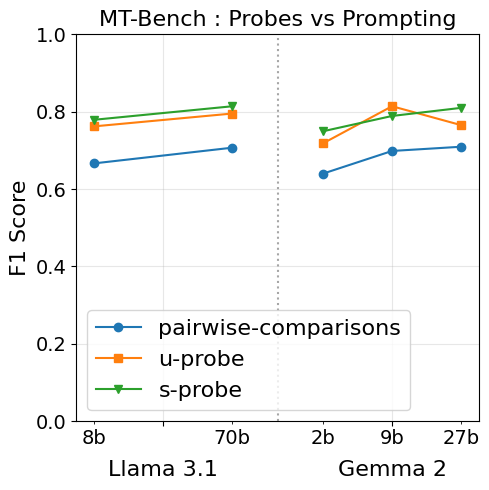

In [22]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
x_pos, xticks, xlabels = 0, [], []
colours = {
    "pairwise": "#1f77b4",
    "u-probe": "#ff7f0e", 
    "s-probe": "#2ca02c"
}
family_full = {
    'llama': 'Llama 3.1',
    'gemma': 'Gemma 2'
}
families = {
    "llama": ["llama-3.1-8b", "llama-3.1-70b"],
    "gemma": ["gemma-2-2b", "gemma-2-9b", "gemma-2-27b"]
}

total_width = 10  # Total plot width to use
gap = total_width / 4  # Gap between family groups
family_width = (total_width - gap) / 2  # Width for each family

minor_xticks = []
minor_xlabels = []

for i, (family, models) in enumerate(families.items()):
    # Calculate x coordinates with even spacing
    start_pos = i * (family_width + gap)
    step = family_width / (len(models) - 1)
    xcoords = [start_pos + j * step for j in range(len(models))]
    
    # get scores
    pc_scores = results.loc[results["method"] == "pairwise-comparisons", "f1"].loc[models] - np.random.normal(0.075, 0.001, len(models))
    u_scores = results.loc[results["method"] == "u-probe", "f1"].loc[models]
    s_scores = results.loc[results["method"] == "s-probe", "f1"].loc[models]
    
    # plot lines
    ax.plot(xcoords, pc_scores, color=colours["pairwise"], label="pairwise-comparisons" if i == 0 else "", marker="o")
    ax.plot(xcoords, u_scores, color=colours["u-probe"], label="u-probe" if i == 0 else "", marker="s")
    ax.plot(xcoords, s_scores, color=colours["s-probe"], label="s-probe" if i == 0 else "", marker="v")
    
    # track positions for labels
    xticks.append(start_pos + family_width/2)
    xlabels.append(family_full[family])
    
    # add minor ticks for model sizes
    minor_xticks.extend(xcoords)
    minor_xlabels.extend([m.split('-')[-1] for m in models])

# Add vertical dotted line between families
middle_x = (total_width - gap) / 2 + gap/2
ax.axvline(x=middle_x, color='grey', linestyle=':', alpha=0.7)

# customise plot
ax.xaxis.remove_overlapping_locs = False
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, fontsize=16, y=-0.075)
ax.set_xticks(minor_xticks, minor=True)
ax.set_xticklabels(minor_xlabels, minor=True, fontsize=14)
ax.set_ylabel("F1 Score", fontsize=16)
ax.set_ylim(0, 1)
ax.set_xlim(-0.5, total_width + 0.5)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=16, loc="lower left")
ax.tick_params(axis='y', labelsize=14)
ax.set_title("MT-Bench : Probes vs Prompting", fontsize=16)
plt.tight_layout()
plt.savefig(f"{GRAPH_PATH}/mtbench_main.png", dpi=400)
plt.show()

In [23]:
model = "llama-3.1-70b"
path = f"{RESULTS_DIR}/mtbench/{model}/contrast"
x1 = t.load(f"{path}_1.pt", weights_only=True).float()
x2 = t.load(f"{path}_2.pt", weights_only=True).float()
x = x1 - x2
# Reduce dimensions using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
x_reduced = pca.fit_transform(x.numpy())

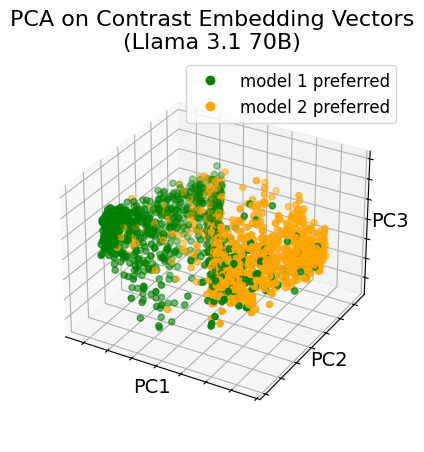

In [25]:
# Create 3D scatter plot
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

colors = ['green' if label == 1 else 'orange' for label in data.labels]
scatter = ax.scatter(x_reduced[:, 0], x_reduced[:, 1], x_reduced[:, 2],
                    c=colors)

ax.set_box_aspect(None, zoom=0.9)

ax.set_xlabel('PC1', fontsize=14, labelpad=-10)
ax.set_ylabel('PC2', fontsize=14, labelpad=-10)
ax.set_zlabel('PC3', fontsize=14, labelpad=-10)
ax.set_title('PCA on Contrast Embedding Vectors\n(Llama 3.1 70B)', fontsize=16)

# Remove tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label='model 1 preferred', markersize=8),
                  Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', label='model 2 preferred', markersize=8)]
ax.legend(handles=legend_elements, fontsize=12)
plt.savefig(f"{RESULTS_DIR}/mtbench/{model}/pca.png", dpi=300)
# plt.show()
plt.savefig(f"{GRAPH_PATH}/mtbench_pca.png", dpi=400)
plt.show()